# Autoencoders for Anomaly Detection

Based on the article at https://bit.ly/2VgNyl7, made for the bonus task of the cyber data analytics class. Download the data and adjust the paths in the next cells.

Requires 
* seaborn
* tensorflow
* keras
* sklearn
* pyplot, pylab

and for visualizing the network also th4e graphviz package. Install directly from the notebook with **!pip install package**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 
DATA_SPLIT_PCT = 0.2

LABELS = ["Normal","Attack"]

# please adjust the dataset paths
NORMAL = 'data/BATADAL_dataset03.csv'
MIXED = 'data/BATADAL_dataset04.csv'

Using TensorFlow backend.


In [2]:
df_normal =  pd.read_csv(NORMAL, encoding="utf-8-sig", skipinitialspace=True)
df_mixed = pd.read_csv(MIXED, encoding="utf-8-sig", skipinitialspace=True)

Harmonize the labels across the datasets to 0 / 1

**WARNING**: THIS TREATS *unlabeled* DATA AS NORMAL, see https://batadal.net/images/rules.pdf for the documentation of the -999 value.


In [3]:
df_mixed.ATT_FLAG.replace([-999, 1], [0, 1], inplace=True)

Drop non-numeric columns, concatenate the dataframes.
We train the autoencoder on the normal data from BATADAL_dataset03 and test on BATADAL_dataset04

In [4]:
df_normal = df_normal.drop(['DATETIME'], axis=1)
df_mixed = df_mixed.drop(['DATETIME'], axis=1)

df = pd.concat([df_normal, df_mixed], ignore_index=True)

Splitting into training, validation, testing, group into classes

In [5]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [6]:
df_train_0 = df_train.loc[df['ATT_FLAG'] == 0]
df_train_1 = df_train.loc[df['ATT_FLAG'] == 1]

df_train_0_x = df_train_0.drop(['ATT_FLAG'], axis=1)
df_train_1_x = df_train_1.drop(['ATT_FLAG'], axis=1)


df_valid_0 = df_valid.loc[df['ATT_FLAG'] == 0]
df_valid_1 = df_valid.loc[df['ATT_FLAG'] == 1]

df_valid_0_x = df_valid_0.drop(['ATT_FLAG'], axis=1)
df_valid_1_x = df_valid_1.drop(['ATT_FLAG'], axis=1)


df_test_0 = df_test.loc[df['ATT_FLAG'] == 0]
df_test_1 = df_test.loc[df['ATT_FLAG'] == 1]

df_test_0_x = df_test_0.drop(['ATT_FLAG'], axis=1)
df_test_1_x = df_test_1.drop(['ATT_FLAG'], axis=1)

Scale the data to 0-1 range

In [7]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['ATT_FLAG'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['ATT_FLAG'], axis = 1))

## Set up a neural network with relu-encoder

In [8]:
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 16
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


This requires pydot and graphviz installed

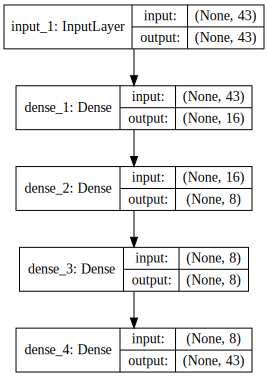

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Train the network

In [10]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Instructions for updating:
Use tf.cast instead.
Train on 8143 samples, validate on 2030 samples
Epoch 1/100
8143/8143 [==============================] - 0s 44us/step - loss: 1.8356 - acc: 0.0456 - val_loss: 1.5945 - val_acc: 0.0754
Epoch 2/100
8143/8143 [==============================] - 0s 22us/step - loss: 1.4447 - acc: 0.0689 - val_loss: 1.2346 - val_acc: 0.0783
Epoch 3/100
8143/8143 [==============================] - 0s 19us/step - loss: 1.1292 - acc: 0.0727 - val_loss: 0.9777 - val_acc: 0.0823
Epoch 4/100
8143/8143 [==============================] - 0s 32us/step - loss: 0.9429 - acc: 0.0580 - val_loss: 0.8607 - val_acc: 0.0670
Epoch 5/100
8143/8143 [==============================] - 0s 27us/step - loss: 0.8636 - acc: 0.0551 - val_loss: 0.8078 - val_acc: 0.0956
Epoch 6/100
8143/8143 [==============================] - 0s 19us/step - loss: 0.8206 - acc: 0.1294 - val_loss: 0.7749 - val_acc: 0.1493
Epoch 7/100
8143/8143 [==============================] - 0s 17us/step - loss: 0.7904 - a

8143/8143 [==============================] - 0s 20us/step - loss: 0.6067 - acc: 0.4417 - val_loss: 0.6061 - val_acc: 0.4320
Epoch 59/100
8143/8143 [==============================] - 0s 18us/step - loss: 0.6054 - acc: 0.4423 - val_loss: 0.6018 - val_acc: 0.4399
Epoch 60/100
8143/8143 [==============================] - 0s 17us/step - loss: 0.6033 - acc: 0.4495 - val_loss: 0.6018 - val_acc: 0.4404
Epoch 61/100
8143/8143 [==============================] - 0s 17us/step - loss: 0.6024 - acc: 0.4466 - val_loss: 0.5994 - val_acc: 0.4202
Epoch 62/100
8143/8143 [==============================] - 0s 17us/step - loss: 0.6008 - acc: 0.4491 - val_loss: 0.5967 - val_acc: 0.4286
Epoch 63/100
8143/8143 [==============================] - 0s 17us/step - loss: 0.5997 - acc: 0.4523 - val_loss: 0.5990 - val_acc: 0.4197
Epoch 64/100
8143/8143 [==============================] - 0s 18us/step - loss: 0.5993 - acc: 0.4525 - val_loss: 0.5988 - val_acc: 0.4453
Epoch 65/100
8143/8143 [==============================

## Validate 

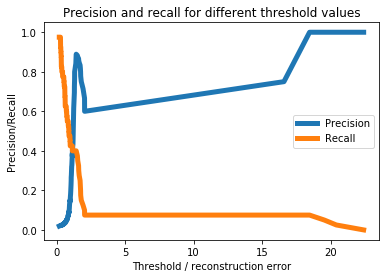

In [11]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['ATT_FLAG'] == 1})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold / reconstruction error')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Evaluate on testing

based on the above plot, choose a fixed threshold when the reconstruction error is too large

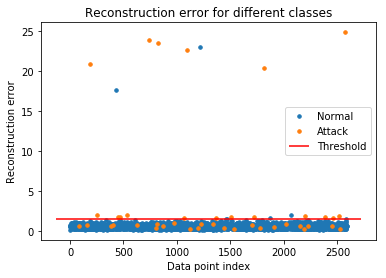

In [12]:
threshold_fixed = 1.5


test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['ATT_FLAG']})
error_df_test = error_df_test.reset_index()

groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### Use autoencoder to predict outliers

Predict *attack* label if reconstruction error larger than the chosen threshold

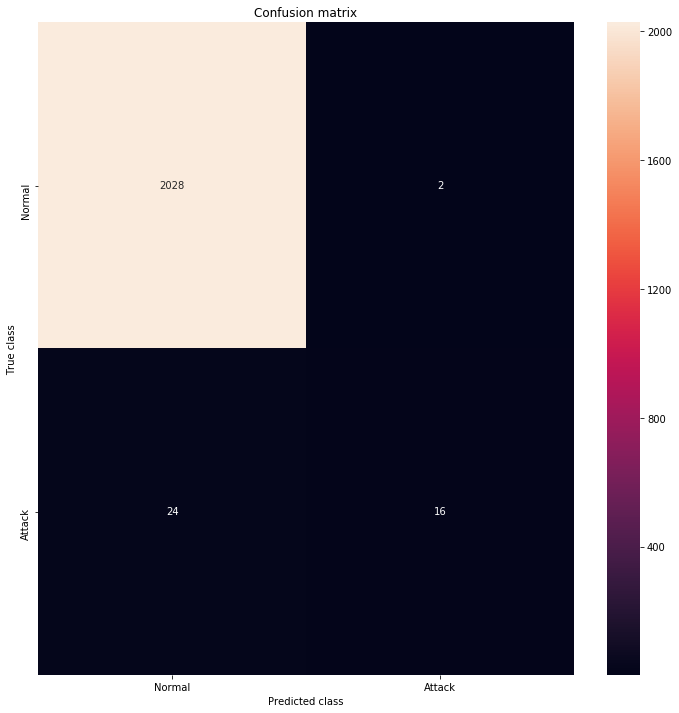

In [13]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Plot the ROC curve for the chosen threshold

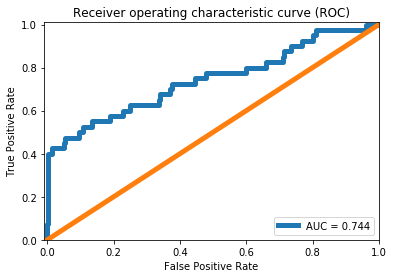

In [14]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()